In [ ]:
import json
import numpy as np
from pyproj import Transformer
import pandas as pd
from shapely import wkt
from shapely.geometry import shape, Polygon, LineString, Point
from tqdm import tqdm
import sys
import networkx as nx
import geopandas as gpd

known_overlap = 9840  # The known overlap (in meters) between Sentinel-2 tiles when they are in the same UTM zone

# Load GeoJSON
with open("3rdparty/sentinel-2-grid/grid.geojson") as f:
    geojson_data = json.load(f)

with open("3rdparty/sentinel-2-grid/grid_pretty.geojson", "w") as f:
    json.dump(geojson_data, f, indent=2)

# EPSG transforms dictionary, same as before (optional if you need)
epsg_transforms = {}

# Tiles dictionary with the structure you want
tiles = {}

to_wgs84 = {}
from_wgs84 = {}

overlap_graph = nx.Graph()

def mean_angle(a1, a2):
    # Compute difference
    diff = a2 - a1

    # Wrap the difference to [-180, 180]
    while diff > 180:
        diff -= 360
    while diff < -180:
        diff += 360

    # Add half the (wrapped) difference to a1
    mid = a1 + diff / 2

    # Normalize result to [-180, 180]
    while mid > 180:
        mid -= 360
    while mid < -180:
        mid += 360

    return mid

def densify_and_project(polygon, from_wgs84, to_wgs84, threshold = 1.0):

    def distance(p1, p2):
        return np.hypot(p2[0]-p1[0], p2[1]-p1[1])

    # Extract coordinates from the polygon (excluding the closing point)
    coords = list(polygon.exterior.coords)
    i = 0
    while i < len(coords) - 1:
        utm_mid = ((coords[i][0] + coords[i+1][0])*0.5, (coords[i][1] + coords[i+1][1])*0.5)
        p0 = to_wgs84(*coords[i])
        p1 = to_wgs84(*coords[i+1])
        wgs84_mid = (mean_angle(p0[0], p1[0]), (p0[1] + p1[1])*0.5)
        wgs84_mid_in_utm = from_wgs84(*wgs84_mid)
        dist = distance(utm_mid, wgs84_mid_in_utm)
        if dist > threshold:
            coords.insert(i + 1, utm_mid)
            if len(coords) > 10000:
                print(list(polygon.exterior.coords))
                print([to_wgs84(x, y) for x, y in polygon.exterior.coords])
                #print(coords[i:i+3])
                raise ValueError("Too many points in polygon, consider increasing the threshold")
        else:
            i += 1

    projected_coords = [to_wgs84(x, y) for x, y in coords]
    return Polygon(projected_coords)

print("Loading tile geometries and projecting to WGS84")
for feature in tqdm(geojson_data.get("features", [])):
#for feature in tqdm(filter(lambda a: a["properties"]["id"][:3] in ("34V", "35V"), geojson_data.get("features", []))):
    sys.stdout.flush()
    props = feature.get("properties", {})
    feature_id = props.get("id") or props.get("name") or "unknown"

    # Extract EPSG code (string)
    epsg_code = props.get("epsg")

    # Create UTM <-> WGS84 transforms
    if epsg_code not in to_wgs84:
        try:
            epsg_int = int(epsg_code)
            to_wgs84[epsg_code] = Transformer.from_crs(f"EPSG:{epsg_int}", "EPSG:4326", always_xy=True).transform
            from_wgs84[epsg_code] = Transformer.from_crs("EPSG:4326", f"EPSG:{epsg_int}", always_xy=True).transform
        except ValueError:
            print(f"Invalid EPSG code: {epsg_code}")

    # Parse the UTM polygon from utmWkt if available
    utm_polygon = None
    utm_wkt = props.get("utmWkt")
    if utm_wkt:
        try:
            utm_geom = wkt.loads(utm_wkt)
            # Unwrap single-polygon multipolygons
            if utm_geom.geom_type == "MultiPolygon" and len(utm_geom.geoms) == 1:
                utm_geom = utm_geom.geoms[0]
            utm_polygon = utm_geom
        except Exception as e:
            print(f"Error parsing utmWkt for feature {feature_id}: {e}")

    # Parse the native WGS84 geometry from GeoJSON geometry
    wgs84_geom = None
    try:
        wgs84_geom = shape(feature.get("geometry"))
    except Exception as e:
        print(f"Error parsing GeoJSON geometry for feature {feature_id}: {e}")
   
    # Store everything in tiles dict
    tile = {
        "id": feature_id,
        "utm_polygon": utm_polygon,
        #"wgs84_polygon": Polygon([to_wgs84[epsg_code](x, y) for x, y in list(utm_polygon.exterior.coords)]),
        "dense_wgs84_polygon": densify_and_project(utm_polygon, from_wgs84[epsg_code], to_wgs84[epsg_code]),
        "epsg_code": epsg_code,
    }

    #for other_tile in tiles.values():
    #    # Check if the polygons overlap
    #    if tile["epsg_code"] == other_tile["epsg_code"]:            
    #        None  # They are in the same UTM zone. There will be no intersection (since we shrank the polygons)
    #    elif tile["dense_wgs84_polygon"].intersects(other_tile["dense_wgs84_polygon"]):
    #        overlap_graph.add_edge(tile["id"], other_tile["id"])

    tiles[feature_id] = tile


Loading tile geometries, shrinking and projecting to WGS84


100%|██████████| 56686/56686 [00:33<00:00, 1674.03it/s]


In [27]:
print("Saving densified tiles to GeoJSON")
# Convert tiles to GeoDataFrame, using the dense WGS84 polygons
dense_tiles = {
    tile_id: {
        "geometry": tile["dense_wgs84_polygon"],
        "id": tile_id,
        "epsg_code": tile["epsg_code"]
    }
    for tile_id, tile in tiles.items()
}
gdf = gpd.GeoDataFrame(dense_tiles).T
gdf.set_geometry("geometry", inplace=True)
gdf.set_crs("EPSG:4326", inplace=True)
gdf.to_file("3rdparty/sentinel-2-grid/densified_grid.geojson", driver="GeoJSON")


Saving densified tiles to GeoJSON


In [ ]:

# Save shrunken polygons to GeoJSON
output_geojson = {
    "type": "FeatureCollection",
    "features": []
}
for tile in tiles.values():
    # Project utm polygon to WGS84 without densification
    feature = {
        "type": "Feature",
        "properties": {
            "id": tile["id"],
            "epsg": tile["epsg_code"]
        },
        "geometry": gpd.GeoSeries(
            [Polygon([to_wgs84[tile["epsg_code"]](x, y) for x, y in list(tile["utm_polygon"].exterior.coords)])]
        ).__geo_interface__
    }
    output_geojson["features"].append(feature)
with open("3rdparty/sentinel-2-grid/shrunken_grid.geojson", "w") as f:
    json.dump(output_geojson, f, indent=2)

In [113]:
print("Neighbors of 35VLH:", list(overlap_graph.neighbors("35VLH")))

Neighbors of 35VLH: ['34VFM', '34VFN', '34VFP']


81


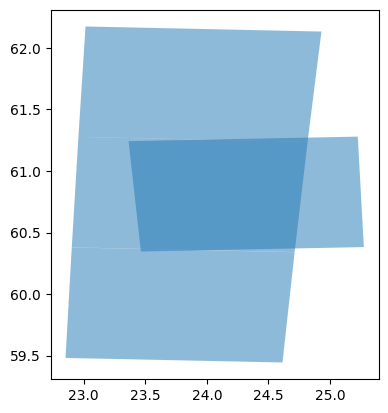

In [121]:
src = [{"geometry":tiles[tile_id]['dense_wgs84_polygon']} for tile_id in overlap_graph.neighbors("35VLH")]
src.append({"geometry":tiles["35VLH"]['dense_wgs84_polygon']})
df = gpd.GeoDataFrame(src)
df.plot(alpha=0.5)
[tiles[tile_id] for tile_id in overlap_graph.neighbors("35VLH")]

print(len(tiles['34VFM']['dense_wgs84_polygon'].exterior.coords))